# Опрделение температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### __Цель проекта:__ Уменьшить потребление электроэнергии на этапе обработки стали с помощью машинного обучения.
Перед нами стоит задача регрессии, значение метрики MAE=6,8 и менее. Целевой признак последняя температура. 

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### План проекта:

1. Создать новые признаки, обработать выбросы, создать целевой признак по первой и последней температуре в каждой партии. Объединить данные в признаки и целевой признак.
2. Разделенить данные в соотношении 1:3. Провести нормализацию данных.
3. Обучить модели (не менее 2-ух) и определение лучшей модели. Проверка лучшей модели на тестовых данных.
4. Сделать отчет.


### Импортируем библиотеки

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Анализ EDA

## 1.1 Подготовка данных об электродах data_arc

In [2]:
try:
    data_arc = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/data_arc.csv")
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
display(data_arc.head())#прочитаем датафрейм и выведим 5 строк

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [3]:
data_arc.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc.describe(include = "all")#посмотрим на статистическую сводку по каждому столбцу

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14875,14876,NaN,NaN
top,NaN,2019-06-10 22:02:03,2019-05-03 11:06:02,NaN,NaN
freq,NaN,2,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.670441,0.452592
std,934.571502,NaN,NaN,0.408159,5.878702
min,1.000000,NaN,NaN,0.030002,-715.504924
25%,806.000000,NaN,NaN,0.395297,0.290991
50%,1617.000000,NaN,NaN,0.555517,0.415962
75%,2429.000000,NaN,NaN,0.857034,0.637371


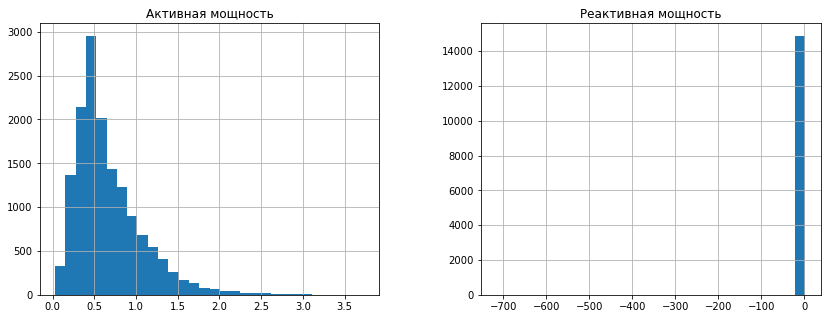

In [5]:
digital_features=data_arc.select_dtypes(exclude=['object', 'int64'])#построим гистограммы для числовых признаков
digital_features.hist(figsize=(14,5), bins=30)
plt.show()

___Комментарии:___ Нам даны данные об электродах. В данных 5 столбцов, в том числе столбец ключи, которые нам показывают числовое значение партий. В таблице содержится активная и реактивная мощность, начало и конец нагрева дугой. Единицы измерения не указываются, но мы знаем что активная мощность измеряется в кВт, а реактивная мощность в ВАр, начало и конец нагрева дугой имеет тип объекта и содержит дату. Данные синхронизированы, каждая следующая строка идет по порядку процесса с началом и концом нагрева дугой. В датафрейме 14876 строк. Активная мощность имеет диапазон от 0,03 до 3,73 кВт, в среднем мы видим вспелск на 0,4. Реактивная мощность имеет диапазон от -715,5 до 2,6 ВАр, в основном все сосредоточено на значении 0,6. Далее мы посмотрим на пропуски, аномалии и зависимости.

In [6]:
data_arc.nunique()#посмотрим какое количество уникальных значений в каждом столбце

key                      3214
Начало нагрева дугой    14875
Конец нагрева дугой     14876
Активная мощность       14869
Реактивная мощность     14866
dtype: int64

In [7]:
data_arc.duplicated().sum()#проверим наличие дубликатов

0

In [8]:
data_arc.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')#проверим пропуски

,0
key,0.00%
Начало нагрева дугой,0.00%
Конец нагрева дугой,0.00%
Активная мощность,0.00%
Реактивная мощность,0.00%


In [9]:
data_arc.columns = data_arc.columns.str.lower()#приведем к нижнему регистру данные
data_arc['начало нагрева дугой'] = pd.to_datetime(data_arc['начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')#переведем дату
data_arc['конец нагрева дугой'] = pd.to_datetime(data_arc['конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [10]:
data_arc.corr()#посмотрим на корреляцию числовых данных

,key,активная мощность,реактивная мощность
key,1.000000,-0.021382,-0.004396
активная мощность,-0.021382,1.000000,0.054437
реактивная мощность,-0.004396,0.054437,1.000000


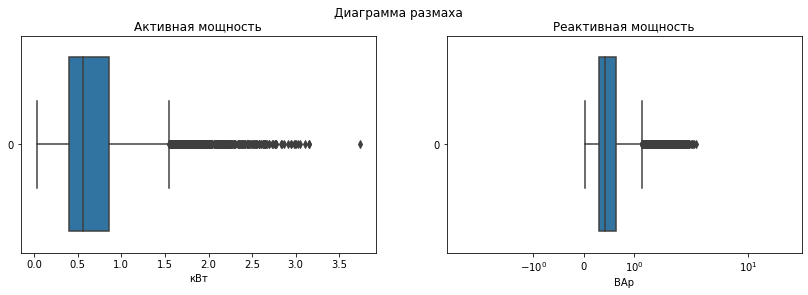

In [11]:
plt.figure(figsize=(14,4))#построим диаграмму размаха
plt.suptitle("Диаграмма размаха")
plt.subplot(121)
plt.title("Активная мощность")
plt.xlabel("кВт")
sns.boxplot(data=data_arc['активная мощность'], orient='h')
plt.subplot(122)
plt.title("Реактивная мощность")
sns.boxplot(data=data_arc['реактивная мощность'], orient='h')
plt.xlabel("ВАр")
plt.xscale('symlog')
plt.xlim(left=-5)
plt.show()

___Комментарии:___ В данном датафрейме ключи имеют 3214 уникальных значений из 14876, остальные повторяются, предположительно что процесс по ключам идет по порядку схемы. Дубликатов и пропусков нет. Активная мощность и реактивная не коррелируют с друг с другом, они не зависят. В активной мощности мы видим выбросы с 1,5 кВт и в соновном до 3,3 кВт. В реактивной мощности также мы видим выбросы от 10*0,2 ВАр, которые мы удалим на следующем этапе.

## 1.2 Подготовка данных о подаче сыпущих материалов(объем)

In [12]:
try:
    data_bulk = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/data_bulk.csv")
except:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
display(data_bulk.head())#прочитаем датафрейм и выведим 5 строк

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
data_bulk.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
data_bulk.describe(include = "all").round(2)#посмотрим на статистическую сводку по каждому столбцу

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


___Комментарии:___ Нам даны данные о подаче сыпучих материалов (объем) разной размерности, всего по ключам сторк 3129, все данные численные и содержат 16 столбцов, в том числе одни ключи, единицы измерения не известны. Далее расмотрим тесноту свзяи между балками.

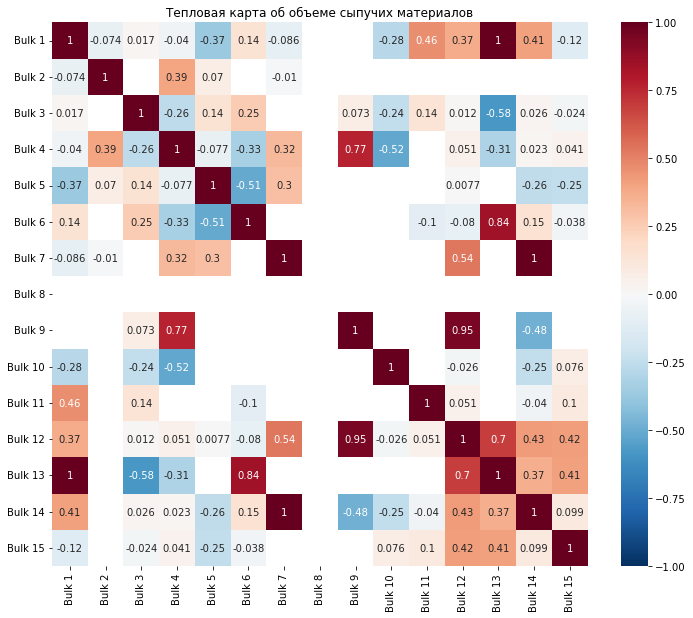

In [15]:
plt.figure(figsize=(12,10))
plt.title("Тепловая карта об объеме сыпучих материалов")
corr_bulk = data_bulk.drop('key', axis=1).corr()
sns.heatmap(corr_bulk, cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True);

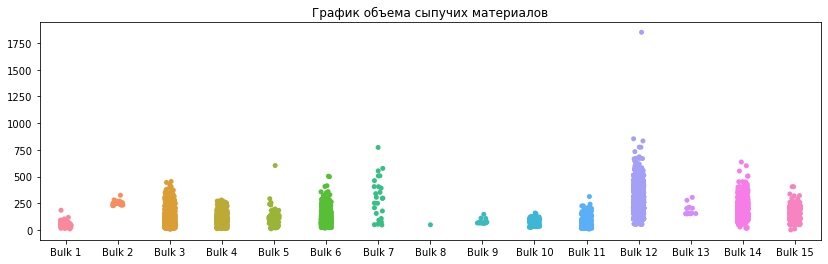

In [16]:
plt.figure(figsize=(14,4))
plt.title("График объема сыпучих материалов")
sns.stripplot(data = data_bulk.drop('key', axis=1));

___Комментарии:____Высокая корреляция рассматривается между Bulk13 и Bulk1, Bulk9 и Bulk4, Bulk13 и Bulk6, Bulk7 и Bulk14, Bulk12 и Bulk9, Bulk12 и Bulk13. Заметная корреляция между Bulk10 и Bulk4, Bulk13 и Bulk3, Bulk6 и Bulk5, Bulk12 и Bulk7. По Bulk8 мы не видим данных, так как там одно значение. Самые большие данные содержатся в Bulk12.

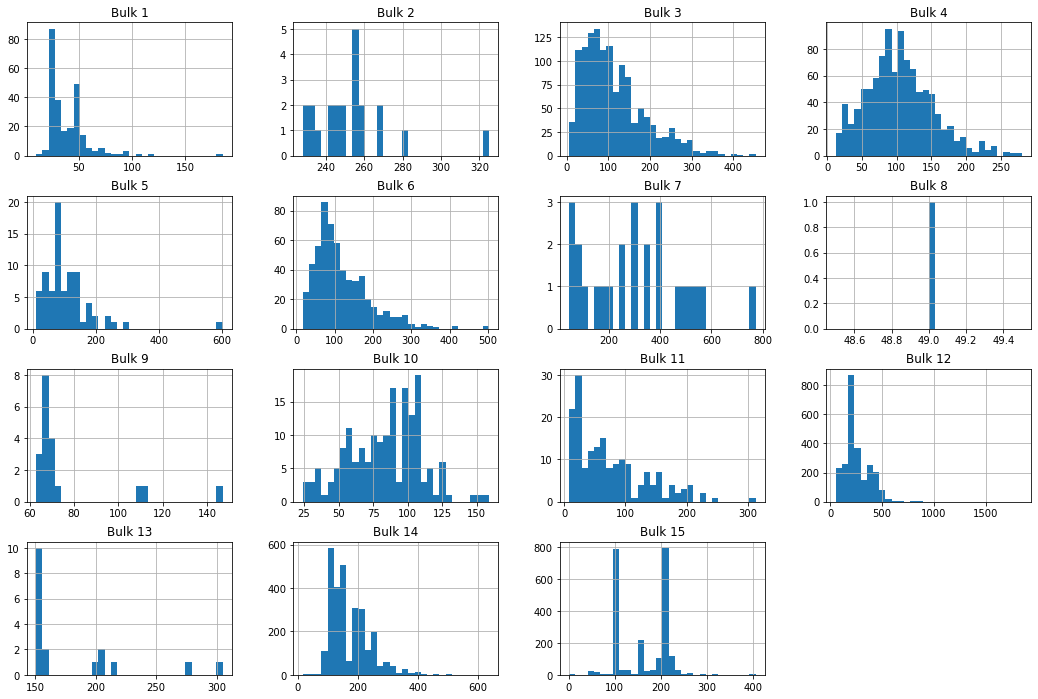

In [17]:
digital_features=data_bulk.select_dtypes(exclude=['int64'])#построим гистограммы для числовых признаков
digital_features.hist(figsize=(18,12), bins=30)
plt.show()

___Комментарии:___ В Bulk1 мы видим выбросы по объему, в основном все данные лежат на значении 25 и 50, Bulk2 также имеет разные объемы подачи, самый большой объем приходится на 255. Bulk3,Bulk4, Bulk6, Bulk10, Bulk11, Bulk14 имеют волнообразную форму по объему вещества, с некоторыми выбрасами. В остальных Bulk мы видим в основном определенные дозированные объемы вещества.

In [18]:
data_bulk.nunique()#посмотрим какое количество уникальных значений в каждом столбце

key        3129
Bulk 1       47
Bulk 2       15
Bulk 3      278
Bulk 4      206
Bulk 5       55
Bulk 6      205
Bulk 7       25
Bulk 8        1
Bulk 9       10
Bulk 10      77
Bulk 11     101
Bulk 12     331
Bulk 13      14
Bulk 14     284
Bulk 15     156
dtype: int64

In [19]:
data_bulk.duplicated().sum()#проверим наличие дубликатов

0

In [20]:
data_bulk.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')#проверим пропуски

,0
key,0.00%
Bulk 14,10.32%
Bulk 12,21.70%
Bulk 15,28.16%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 6,81.59%
Bulk 1,91.95%
Bulk 11,94.34%
Bulk 10,94.38%


In [21]:
data_bulk.columns = data_bulk.columns.str.lower()#приведем к нижнему регистру данные
data_bulk.fillna(value= 0 , inplace= True )

In [22]:
data_bulk.isna().sum()#проверим пропуски в столбцах

key        0
bulk 1     0
bulk 2     0
bulk 3     0
bulk 4     0
bulk 5     0
bulk 6     0
bulk 7     0
bulk 8     0
bulk 9     0
bulk 10    0
bulk 11    0
bulk 12    0
bulk 13    0
bulk 14    0
bulk 15    0
dtype: int64

___Комментарии:___ Дубликатов в столбцах нет, но есть пропуски, возможно они потому, что на момент стадии технологического процесса, эту добавку не добавлялили, поэтому мы заполнили значением 0 пропущенные NaN.

## 1.3 Подготовка данных о подаче сыпущих материалов (время)

In [23]:
try:
    data_bulk_time = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/data_bulk_time.csv")
except:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
display(data_bulk_time.head())#прочитаем датафрейм и выведим 5 строк

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [24]:
data_bulk_time.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [25]:
data_bulk_time.duplicated().sum()#проверим наличие дубликатов

0

In [26]:
data_bulk_time.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')#проверим пропуски

,0
key,0.00%
Bulk 14,10.32%
Bulk 12,21.70%
Bulk 15,28.16%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 6,81.59%
Bulk 1,91.95%
Bulk 11,94.34%
Bulk 10,94.38%


In [27]:
data_bulk_time.fillna(value= 0 , inplace= True )#заполним пропуски 0

In [28]:
data_bulk_time.isnull().sum()#проверим пропуски в столбцах

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

In [29]:
data_bulk_time.columns = data_bulk_time.columns.str.lower()#приведем к нижнему регистру данные

In [30]:
data_bulk_time[['bulk 1','bulk 2','bulk 3','bulk 4','bulk 5','bulk 6','bulk 7','bulk 8','bulk 9','bulk 10','bulk 11','bulk 12','bulk 13','bulk 14','bulk 15']] \
= data_bulk_time[['bulk 1','bulk 2','bulk 3','bulk 4','bulk 5','bulk 6','bulk 7','bulk 8','bulk 9','bulk 10','bulk 11','bulk 12','bulk 13','bulk 14','bulk 15']]\
.apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

___Комментарии:___ Данные о времени сыпучих материалов похожи на данные об объеме сыпучих материалов, такое же количество строк 3129, и так же 16 столбцов, в том числе ключи. Пропуски соответсвенно такие же, поэтому мы заполнили их 0, т.е. в это время добавки не было. Также мы перевели тип время в дату.

## 1.4 Подготовка данных о продувке сплава газом

In [31]:
try:
    data_gas = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/data_gas.csv")
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
display(data_gas.head())#прочитаем датафрейм и выведим 5 строк

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [32]:
data_gas.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [33]:
data_gas.describe(include = "all").round(2)#посмотрим на статистическую сводку по каждому столбцу

,key,Газ 1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
max,3241.00,78.00


In [34]:
data_gas.columns = data_gas.columns.str.lower()#приведем к нижнему регистру данные

In [35]:
data_gas.duplicated().sum()#проверим наличие дубликатов

0

In [36]:
data_gas.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')#проверим пропуски

,0
key,0.00%
газ 1,0.00%


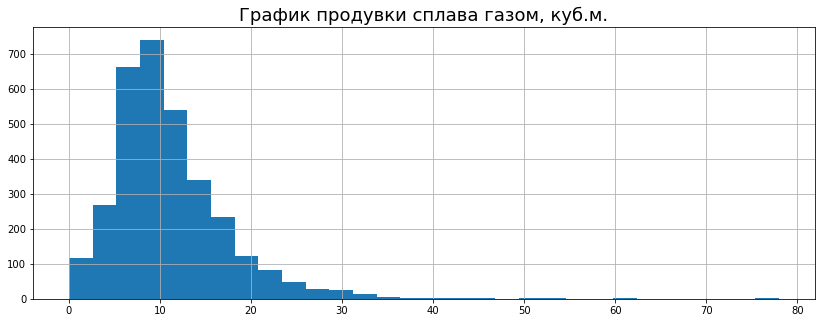

In [37]:
digital_gas=data_gas.select_dtypes(exclude=['int64'])#построим гистограмму
digital_gas.hist(figsize=(14,5), bins=30)
plt.title("График продувки сплава газом, куб.м.", fontsize=18)
plt.show()

__Комментарии:___ В данных о продувке сплава газом два столбца, газ и ключи, 3239 строк. Пропусков нет, дубликатов тоже. Минимальный объем газа 0,01, максимальный 78. В основном мы видим всплеск на 7-10 куб.м.

## 1.5 Подготовка данных о результатах измерения температуры

In [38]:
try:
    data_temp = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/data_temp.csv")
except:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
display(data_temp.head())#прочитаем датафрейм и выведим 5 строк

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [39]:
data_temp.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [40]:
data_temp.describe(include = "all").round(2)#посмотрим на статистическую сводку по каждому столбцу

,key,Время замера,Температура
count,15907.00,15907,13006.00
unique,NaN,15907,NaN
top,NaN,2019-05-03 11:16:18,NaN
freq,NaN,1,NaN
mean,1607.88,NaN,1591.84
std,942.21,NaN,21.38
min,1.00,NaN,1191.00
25%,790.00,NaN,1581.00
50%,1618.00,NaN,1591.00
75%,2427.00,NaN,1601.00


In [41]:
data_temp.columns = data_temp.columns.str.lower()#приведем к нижнему регистру данные
data_temp['время замера'] = pd.to_datetime(data_temp['время замера'], format='%Y-%m-%d %H:%M:%S')#переведем дату

In [42]:
data_temp.isnull().sum()#проверим пропуски

key                0
время замера       0
температура     2901
dtype: int64

In [43]:
data_temp.duplicated().sum()#проверим наличие дубликатов

0

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


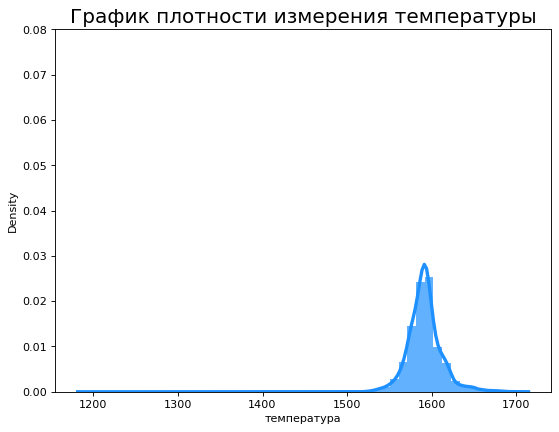

In [44]:
plt.figure(figsize=(8,6), dpi= 80)
sns.distplot(data_temp['температура'], color="dodgerblue", label="температура", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
plt.ylim(0, 0.08)
plt.title('График плотности измерения температуры', fontsize=18)
plt.show()

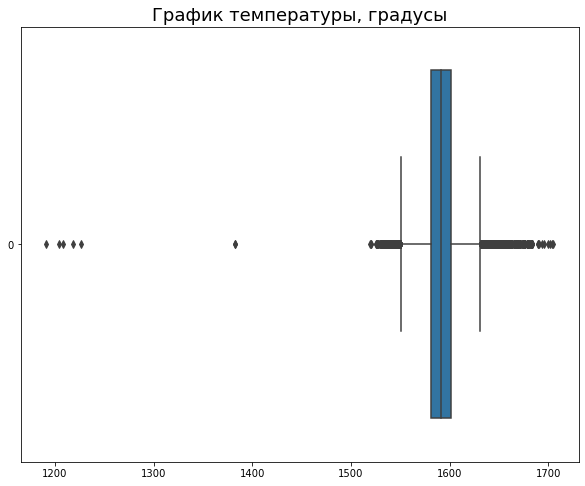

In [45]:
plt.figure(figsize=(10, 8))#построим диаграмму размаха
sns.boxplot(data=data_temp['температура'], orient='h')

plt.title("График температуры, градусы", fontsize=18)
plt.show()

___Комментарии:___ Данные о результатах измерения температуры содержат три столбца, в том числе ключи и 15907 строк. Время замера мы перевели в тип объекта дату. Пропущенные данные в столбце температура, заменим нулем, так как здесь время не замерялось. Также мы видим распредление по графику плотности, в основном градусы сосредоточены в диапазоне от 1575 до 1625. Также есть выбросы, такой температуры не может быть при нагревании стали, поэтому выбросы удалим ниже 1500.

## 1.6 Подготовка данных о проволочных материалах (объем)

In [46]:
try:
    data_wire = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/data_wire.csv")
except:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
display(data_wire.head())#прочитаем датафрейм и выведим 5 строк

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_wire.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [48]:
data_wire.describe(include = "all").round(2)#посмотрим на статистическую сводку по каждому столбцу

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


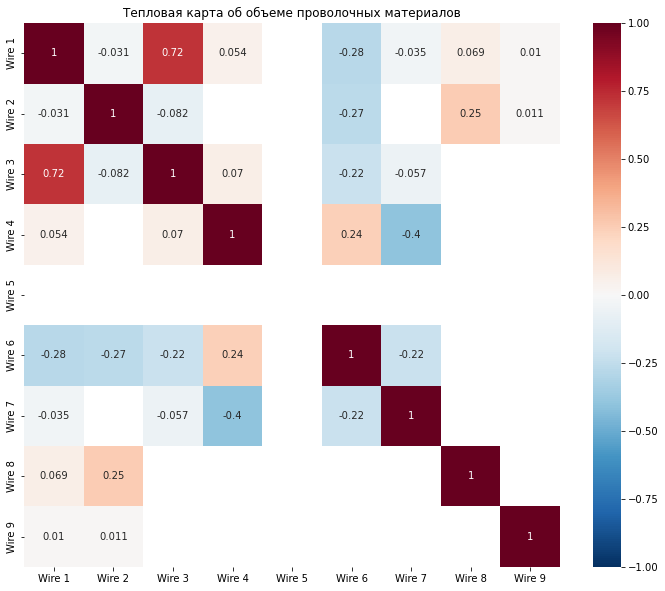

In [49]:
plt.figure(figsize=(12,10))
plt.title("Тепловая карта об объеме проволочных материалов")
corr_wire = data_wire.drop('key', axis=1).corr()
sns.heatmap(corr_wire, cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True);

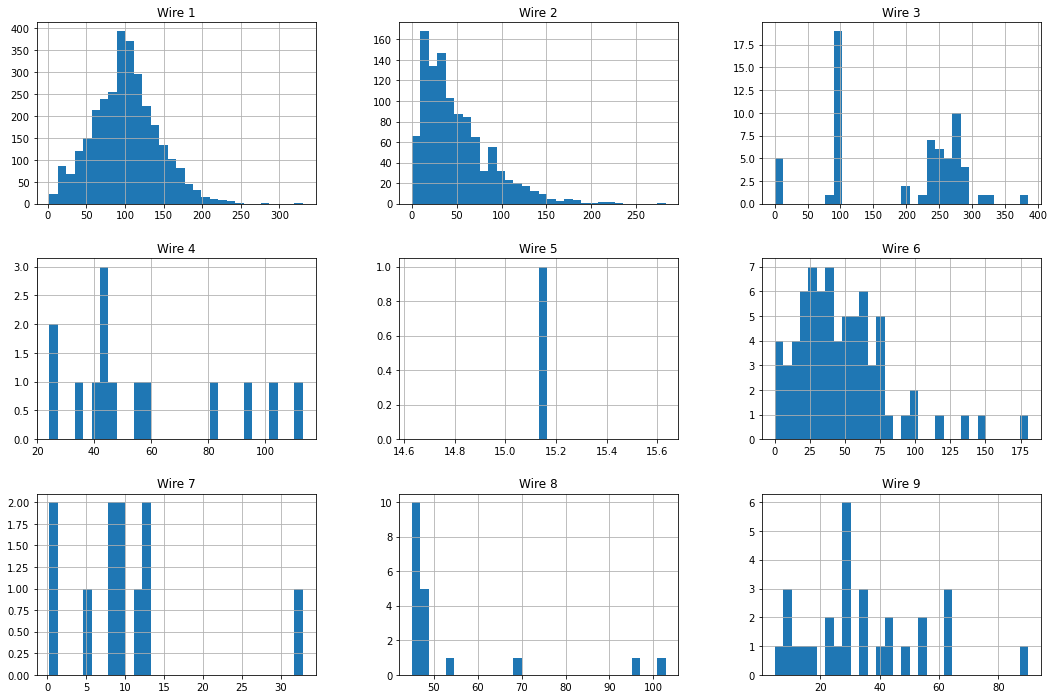

In [50]:
digital_wire=data_wire.select_dtypes(exclude=['int64'])#построим гистограммы для числовых признаков
digital_wire.hist(figsize=(18,12), bins=30)
plt.show()

In [51]:
data_wire.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')#проверим пропуски

,0
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 6,97.63%
Wire 3,97.96%
Wire 9,99.06%
Wire 8,99.38%
Wire 4,99.55%
Wire 7,99.64%
Wire 5,99.97%


In [52]:
data_wire.columns = data_wire.columns.str.lower()#приведем к нижнему регистру данные
data_wire.fillna(value= 0 , inplace= True ) #заполним пропуски 0
data_wire.isnull().sum()#проверим пропуски в столбцах

key       0
wire 1    0
wire 2    0
wire 3    0
wire 4    0
wire 5    0
wire 6    0
wire 7    0
wire 8    0
wire 9    0
dtype: int64

___Комментарии:___ Данные о проволочных материалах содержат 3081 строк, 10 столбцов. Большая часть значений находится в wire1 и wire2, в остальных столбцах значений вещества горазда меньше, следовательно первых двух веществ добавляют чаще. По тепловой карте мы видим сильную корреляцию между wire1 и wire3, так же wire1 и wire4, в остальных прослеживается слабая зависимость. По гистограмме мы видим в wire 1 пик приходится на отметке 110, данные волнообразны. В wire 2 в основном данные приходятся на значении 70. Остальные wire в основном представляют один пик. В данных есть пропуски, которые мы заполнили 0, так как считаем, что этот ингридиент не добавлялся в процессе.

## 1.7 Подготовка данных о проволочных материалах (время)

In [86]:
try:
    data_wire_time = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/data_wire_time.csv")
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(data_wire_time.head())#прочитаем датафрейм и выведим 5 строк

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data_wire_time.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [55]:
data_wire_time.duplicated().sum()#проверим наличие дубликатов

0

In [56]:
data_wire_time.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')#проверим пропуски

,0
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 6,97.63%
Wire 3,97.96%
Wire 9,99.06%
Wire 8,99.38%
Wire 4,99.55%
Wire 7,99.64%
Wire 5,99.97%


In [57]:
data_wire_time.columns = data_wire_time.columns.str.lower()#приведем к нижнему регистру данные
data_wire_time.fillna(value= 0 , inplace= True )#заполним пропуски 0
data_wire_time.isnull().sum()#проверим пропуски в столбцах

key       0
wire 1    0
wire 2    0
wire 3    0
wire 4    0
wire 5    0
wire 6    0
wire 7    0
wire 8    0
wire 9    0
dtype: int64

In [58]:
data_wire_time[['wire 1','wire 2','wire 3','wire 4','wire 5','wire 6','wire 7','wire 8','wire 9']] \
= data_wire_time[['wire 1','wire 2','wire 3','wire 4','wire 5','wire 6','wire 7','wire 8','wire 9']]\
.apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

___Комментарии:___ Данные о времени проволочных материалов похожи на данные об объеме проволочных материалов, такое же количество строк 3081, и так же 10 столбцов, в том числе ключи. Пропуски соответсвенно такие же, поэтому мы заполнили их 0, т.е. в это время ингридиента не было. Также мы перевели тип время в дату.

## Вывод по этапу 1:

Изучили и проанализировали данные в 7 таблицах. Были обнаружины пропуски, которые мы отработали, выбросы, которые обработаем в следующем этапе и несоответствие типов данных, которые мы также отработали. Данные асинхронизированы, но внутри каждого датасета синхронизированы, которые нам помогут в дальнейшем выделить признаки и целевой признак. Были пстроены графики распределения, размаха, столбчатые диаграммы для визуализации данных, также мы проанализировали детально каждый датасет и сделали по каждому выводы.

На втором этапе мы удалим аномалии из обучающей выборки, создадим новые признаки, разделим выборки и будем обучать модель, для выявления лучшей.

## 1.5 План работы

1. Создать новые признаки, обработать выбросы, создать целевой признак по первой и последней температуре в каждой партии. Объединить данные в признаки и целевой признак.
2. Разделенить данные в соотношении 1:3. Провести нормализацию данных.
3. Обучить модели (не менее 2-ух) и определение лучшей модели. Проверка лучшей модели на тестовых данных. 
4. Отчет о проекте.

#  2. Подготовка признаков

### 2.1 Обрабатка выбросов

In [59]:
data_arc = data_arc[(data_arc['реактивная мощность']>0)]#удалим выбросы

In [60]:
data_temp = data_temp[(data_temp['температура']>=1500)]#удалим выбросы

In [61]:
p = data_temp.loc[data_temp['температура'].isna()]#сделаем срез со всеми nan столбца температура и сделаем лист
t = list(p.index)

In [62]:
res = data_temp.groupby("key").filter(lambda x: x["температура"].unique().tolist() not in t)
#сгруппируем данные и сделаем фильтр по уникальным значениям чтобы исключить партии с пропущенными значениями
print(res.head())

   key        время замера  температура
0    1 2019-05-03 11:16:18       1571.0
1    1 2019-05-03 11:25:53       1604.0
2    1 2019-05-03 11:29:11       1618.0
3    1 2019-05-03 11:30:01       1601.0
4    1 2019-05-03 11:30:39       1613.0


In [63]:
res.isnull().sum()#проверим пропуски в столбцах

key             0
время замера    0
температура     0
dtype: int64

### 2.2 Добавление и объединение данных

Для того, чтобы узнать сколько энергии затратил ковш, нам нужно найти работу, которая измеряется в джоулях, формула сследующая A = P * t, где A - работа, дж, P - активная мощность, кВт, t- время нагрева дугой, сек. Этот признак мы возьмем для будущего датасета.

In [64]:
data_arc['работа'] = data_arc['активная мощность']*((data_arc['конец нагрева дугой']\
                                                     -data_arc['начало нагрева дугой'])/ np.timedelta64 ( 1 , 's'))
print(data_arc.head())

   key начало нагрева дугой конец нагрева дугой  активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.692755   

   реактивная мощность      работа  
0             0.687084  222.541395  
1             0.520285  149.037310  
2             0.498805  128.030509  
3             1.062669  605.667332  
4             0.414397  102.527702  


In [65]:
data_temp_1 = res.groupby('key').agg(['first', 'last']).reset_index()#сгруппируем температуру по партиям
data_temp_1.columns = ['key', 'time_first', 'time_last', 'температура first', 'температура last']#назовем столбцы
display(data_temp_1.head())#выведим 5 строк

,key,time_first,time_last,температура first,температура last
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [66]:
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()#сгруппируем данные остальных таблиц
#чтобы потом соединить в одну таблицу

In [67]:
data_gas = data_gas.groupby(by = 'key', as_index = False).sum()

In [68]:
data_temp_1

,key,time_first,time_last,температура first,температура last
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...
3210,3237,2019-08-31 22:44:04,2019-08-31 22:44:04,1569.0,1569.0
3211,3238,2019-08-31 23:30:31,2019-08-31 23:30:31,1584.0,1584.0
3212,3239,2019-09-01 01:31:47,2019-09-01 01:31:47,1598.0,1598.0
3213,3240,2019-09-01 02:39:01,2019-09-01 02:39:01,1617.0,1617.0


В датафрейме data_temp_1 мы заметили, что в некоторых партиях начальная и конечная температуры одинаковые, значит был всего один замер, удалим эти партии.

In [69]:
data_temp_1 = data_temp_1.loc[~data_temp_1['time_first'].isin(data_temp_1['time_last'])]
data_temp_1

,key,time_first,time_last,температура first,температура last
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0


In [70]:
data = (
    data_temp_1.merge(data_arc, on='key', how='inner')
    .merge(data_gas, on='key', how='inner')
    .merge(data_bulk, on='key', how='inner')
    .merge(data_wire, on='key', how='inner')
)#соединяем все подготовленные таблицы
data.head()

,key,time_first,time_last,температура first,температура last,активная мощность,реактивная мощность,работа,газ 1,bulk 1,...,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,4.878147,3.183241,1207.804249,29.749986,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,3.052598,1.998112,733.816470,12.555561,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,2.525882,1.599076,443.583327,28.554793,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,3.209250,2.060298,670.663327,18.841219,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,3.347173,2.252643,997.496095,5.413692,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
data['delta_time'] = (data['time_last']-data['time_first']).dt.total_seconds()
#сделаем новый признак, чтобы посчитать сколько секундр ушло на одну партию и добавим ее в выборку

In [72]:
data = data.drop(['key', 'активная мощность', 'реактивная мощность',\
                  'bulk 8', 'wire 5'], axis=1)
#удалим данные с временем, так же bulk 8 и wire 5 так они всего по одному ингридиенту
#у нас есть работа, поэтому удалим мощности

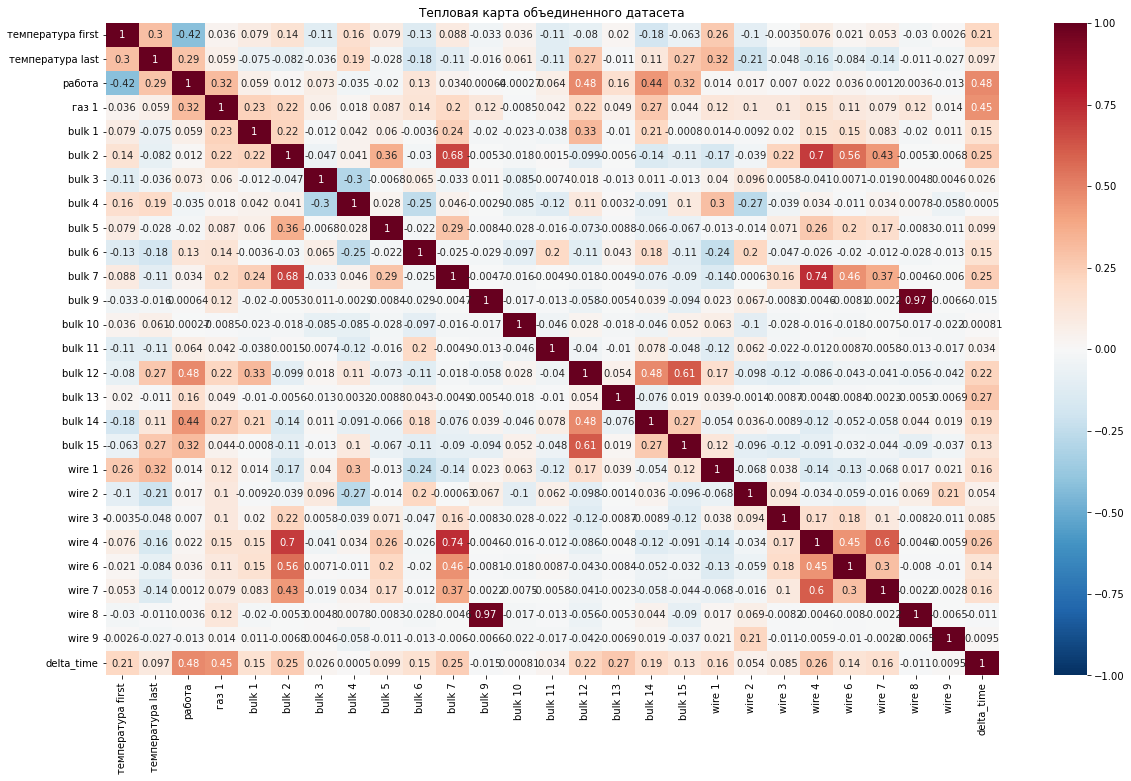

In [73]:
plt.figure(figsize=(20,12))
plt.title("Тепловая карта объединенного датасета")
sns.heatmap(data.corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True);

Из тепловой карты мы видим что сильно коррелируют признаки bulk 9 и wire 8 поэтому удалим один из признаков, пусть будет bulk 9.

In [74]:
data = data.drop(['bulk 9'], axis=1)

# 3.  Анализ моделей

## 3.1 Деление выборки

In [75]:
features = data.drop(['температура last', 'time_first', 'time_last'], axis=1)#выделим признаки
target = data['температура last']#выделим целевой признак

In [76]:
RANDOM_STATE = 100423
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)#поделим выборки
print(f'''Количество объектов в тестовой выборке: {features_test.shape[0]} 
Колчиество объектов в тестовом целевом признаке: {target_test.shape[0]}''')
print(f'''Количество обектов на обучающей выборке: {features_train.shape})
Количество объектов на тестовой выборке: {features_test.shape}''')

Количество объектов в тестовой выборке: 583 
Колчиество объектов в тестовом целевом признаке: 583
Количество обектов на обучающей выборке: (1746, 25))
Количество объектов на тестовой выборке: (583, 25)


## 3.2 Масштабирование признаков для линейной модели

In [77]:
scaler = StandardScaler()#масштабируем признаки для линейной регрессии
scaler.fit(features_train)
features_train_numeric = scaler.transform(features_train)
print(f'''Количество обектов на обучающей выборке: {features_train_numeric.shape}''')

Количество обектов на обучающей выборке: (1746, 25)


## 3.3 Обучение моделей

### Линейная регрессия

In [78]:
pipeline = Pipeline(
 [
 ('selector', SelectKBest(f_regression)),
 ('model', LinearRegression())
 ]
)
search = GridSearchCV(
 estimator = pipeline,
 param_grid = {'selector__k':[3,4,5,6,7,8,9,10]},
 n_jobs=-1,
 scoring="neg_mean_absolute_error",
 verbose=3
)
search.fit(features_train_numeric, target_train)
mae_lr = (search.best_score_ * -1)

print('MAE на обучающей выборке LinearRegression:', mae_lr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
MAE на обучающей выборке LinearRegression: 6.37706983280812


### Случайный лес

In [79]:
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
model_dtr = GridSearchCV(model_dtr, param_grid={'max_depth': range(1, 5)}, 
                       cv=100, scoring='neg_mean_absolute_error', n_jobs=-1)
model_dtr.fit(features_train, target_train)
mae_dtr = (model_dtr.best_score_ * -1)

print('Значение MAE для DecisionTreeRegressor:', mae_dtr)

Значение MAE для DecisionTreeRegressor: 7.376142499988374


### Градиентный бустинг catboost

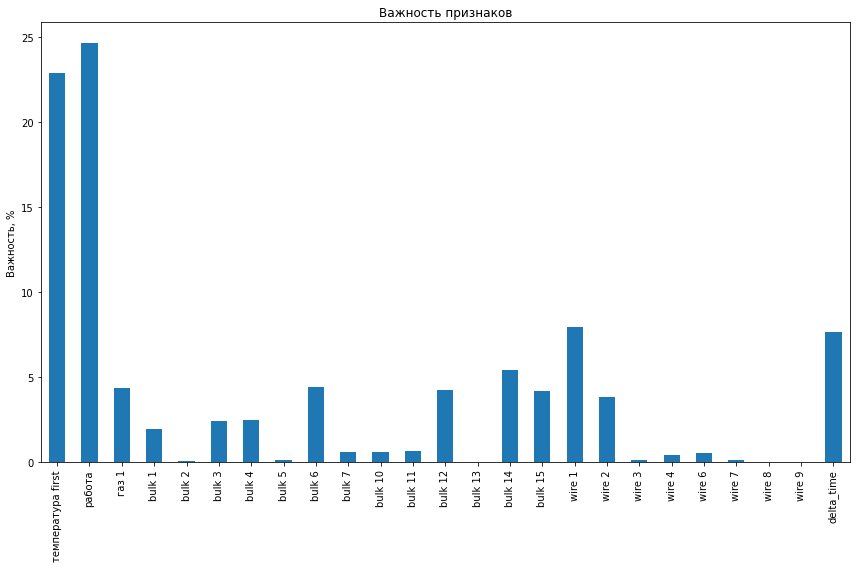

In [80]:
model_cat = CatBoostRegressor(silent=True)
model_cat.fit(features_train, target_train)
cat_imp = pd.Series(model_cat.get_feature_importance(),
                         data.drop(['температура last', 'time_first', 'time_last'], axis=1).columns)
fig, ax = plt.subplots(figsize=(12,8))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()


In [81]:
param_cv = [{
'learning_rate': [0.05, 0.1],
'n_estimators': range(100, 500, 100),
'random_state': [RANDOM_STATE]
}]
model_cat_cv = GridSearchCV(model_cat, param_grid = param_cv, scoring = 'neg_mean_absolute_error', cv=5)
model_cat_cv.fit(features_train, target_train)
mae_cat = (model_cat_cv.best_score_ * -1)

print('MAE на тренировочных данных CatBoostRegressor:', mae_cat)

MAE на тренировочных данных CatBoostRegressor: 5.757461250224594


### Градиентный бустинг LGBM

In [82]:
model_light = LGBMRegressor()
parametrs_lght = [{'num_leaves': [4, 80, 100], 'learning_rate': [0.1, 0.3, 0.5], 'random_state': [RANDOM_STATE]}]

model_light = GridSearchCV(model_light, parametrs_lght, scoring = 'neg_mean_absolute_error') 
model_light.fit(features_train, target_train)
mae_light = (model_light.best_score_ * -1)
print("Значение MAE для LGBMRegressor:", mae_light)

Значение MAE для LGBMRegressor: 5.964344715607161


## 3.4 Проверяем лучшую модель

Так как лучшая mae у нас получилось на градиентном бустинге библиотеки CatBoost (mae = 4,9), мы используем ее на тестовой выборке

In [83]:
predict_cat_test = model_cat_cv.predict(features_test)

mae_cat_test = mean_absolute_error(target_test, predict_cat_test)
print('MAE на тестовых данных CatBoostRegressor:', mae_cat_test)

MAE на тестовых данных CatBoostRegressor: 5.753436602705284


Комментарии:___ Мы получили MAE менее 6,8 на тестовой выборке модели CatBoostRegressor.

##  3.5 Сравнение с константной моделью

In [84]:
dummy_mean = DummyRegressor(strategy = 'mean').fit(features_train, target_train)
#выберим стратегию расчета по среднему и обучим на обучающей модели
predict_dummy_mean = dummy_mean.predict(features_test)
mae_dummy_test = mean_absolute_error(target_test, predict_dummy_mean)

In [85]:
print('Итоговая MAE по предсказаниям на тестовой выборке Dummy:', mae_dummy_test)

Итоговая MAE по предсказаниям на тестовой выборке Dummy: 8.130447639200806


____Вывод:___ На втором этапе мы обработали выбросы в реактивной мощности и целевом признаке температуры. Разделили партии на температуру до замера и после замера, удалили партии, в которых температура до и после была не изменной. Мы объединили получившиеся таблицы, сгруппировав их предварительно по партиям в одну единую таблицу, в которую также добавили новый признак-работа, измеряющаяся в джоулях, и время, между разницей до и после обработки, измерящаяся в секундах. После объединения таблиц, мы обнаружили сильную корреляцию между bulk 9 и wire 8, мы приняли решение убрать bulk 8, так же мы удалили bulk 8, wire 5, так как их было всего по одному ингридиенту, key и мощности, в связи с тем, что у нас есть столбец работа. Мы разделили выборки, целевой признак является температура last. Для линейной регрессии мы масштабировали признаки, MAE показал 6,3, так же мы использовали еще три модели на обычных признаках - случайный лес, градиентный бустинг light и catboost. В итоге выиграла модель градиентного бустинга catboost. Самые важные признаки для catboost являлись изначальная температура, работа, wire 1 и delta_time(время разницы до измерения и после измерения). В итоге MAE градиентного бустинга cаtboost на обучающей выборки 5,75, и на тестовой 5,75 по сравнению с константной моделью 8,13. Мы сделали вывод что модель приемлема.

# 4. Отчет

<br> **ЦEЛЬ ПРОЕКТА** - <i> уменьшить потребление электроэнергии на этапе обработки стали с помощью машинного обучения.<i><br> 

<br> Перед нами стояла задача регрессии, значение метрики <= 6,8. <i>Целевой признак - последняя температура.</i> <br> Мы подготовили следующий план для реальизации цели:<br>
    <ol>
    <li>Анализ ЕDA</li>
    <ul>
        <li>Подготовка данных об электродах</li>
        <li>Подготовка данных о подаче сыпучих материалов (объем)</li>
        <li>Подготовка данных о подаче сыпучих материалов (время)</li>
        <li>Подготовка данных о продувке сплава газом</li>
        <li>Подготовка данных о результатах измерения температуры</li>
        <li>Подготовка данных о проволочных материалов (объем)</li>
        <li>Подготовка данных о проволочных материалов (время)</li>
    </ul>
    <li>Подготовка признаков</li>
        <ul>
        <li>Обработка выбросов</li>
        <li>Добавление и объединение данных</li>
    </ul>
    <li>Анализ моделей</li>
        <ul>
        <li>Деление выборки</li>
        <li>Масштабирование признаков для линейной модели</li>
    </ul>
        <li>Обучение моделей</li>
        <ul>
        <li>Проверяем лучшую модель</li>
        <li>Сравнение с константной моделью</li>
    </ul>
    <li>Отчет</li>
    </ol>
    <br> Нам даны семь файлов с данными. На первом этапе мы провели анализ по каждому датасету. Выявили, что в признаках реактивная мощность, температура есть выбросы, которые в следующем этапе мы обработали. По объему сыпучих материалов мы заметили сильную корреляцию между некоторыми bulk, так же мы заметили что всего один ингридиент в bulk 8, на следующем этапе мы решили его удалить. В столбцах bulk мы так же увидели пропуски, которые мы заполинили значением 0, сделав вывод, что подачи этого bulk не было осуществлено. Больше всего значений было в bulk 12. По времени подаче сыпучих материалов мы обнаружили, что некоторые bulk подаются одновременно, пропуски мы заполнили аналогично нулем. В продувке сплава газом мы заметили всплеск от 7 до 10 куб.м. По результатам измерения температуры мы обнаружили пропуски, которые мы в следующем этапе удалили, так же выбросы. В основном температура была сосредоточена в диапазоне от 1575 до 1675 градусов. По объему проволочных материалов нам даны 9 столбцов, больше всего объема было в wire 1, который показывал сильную зависимость с 3 и 4 wire. Так же мы заметили, что wire 5 имеет один ингридиент, поэтому мы удалили его. Мы заполнили пропуски значением 0, как в аналогии с bulk. В данных о времени проволочных материалах, мы так же заметили что добавляется сразу несколько проволочных материалов.</br>
    <hr>
    <br> Во втором пункте плана мы удалили выбросы, в том числе температуру ниже 1500 градусов. Создали новый признак - работа, измеряющийся в кВт/сек, по формуле:</br>
    <br>P = A * t, где A - активная мощность, а t - время затраченное на нагрев дугой</br>
    <br>Далее мы сгруппировали датасеты по партиям, и обнаружили, что в некоторых партиях температура не измерялась, поэтому мы эти партии удалили. Далее создали новый признак время, как разница между начальной и конечной температуры. После того, как были готовы все признаки и сформированные датасеты по партиям, мы объединили данные в одну таблицу и назвали ее data. Сформировав по данным data тепловую карту, мы обнаружили сильные зависимости между bulk 9 и wire 5. Мы решили удалить один из столбцов, bulk 9. Так же в наши новые данные не входила активная и реактивная мощность, в свзяи с этим у нас был признак работа.</br>
    <hr>
    <br>В третьем этапе мы выделили целевой признак - последняя температура в каждой партии. Поделили выборку на обучающую и тестовую как 3:1. Для линейной регрессии мы масштабировали признаки.</br>
    <hr>
    <br>Для обучения мы использовали следующие модели:</br>
        <ul>
        <li>LinearRegression</li>
        <li>DecisionTreeRegressor</li>
        <li>CatBoostRegressor</li>
        <li>LGBMRegressor</li>
    </ul>
    <br>Самая низкая метрика MAE показала на модели CatBoostRegressor - 5,75. Для данной модели мы построили график значимости признаков и обнаружили, что самые значимые признаки являлись работа, замер первой температуры в партии, wire 1 и время разницы между первой и последней температуры. Мы проверили модель на тестовой выборке, МАЕ получилось 5,75. Сравнили нашу метрики со стратегией среднего значения DummyRegressor и получили на тестовых данных MAE 8,13. Отсюда сделали вывод, что наша модель приемлема.</br>
    <br> **Лучшие параметры модели CatBoostRegressor:**</br>
    <br>param = [{
'learning_rate': [0.05, 0.1],
'n_estimators': range(100, 500, 100),
'random_state': [100423]
}], cv=5</br>
    <hr>
   <br>Подбробно расскажем о значимости факторов лучшей модели CatBoostRegressor, чтобы вы могли сравнить наши данные проводя эксперемент для экономии электропотребления. Наша модель выделила самый большой признак работа, которая составляет 25% от общего числа признаков. Она состоит из активной мощности и времени затраченного на нагрев дугой. Первоначальная температура составляет 23%, т.е. эти два фактора имеют наибольшее влияние на предсказание, и являются значимыми. 7,5% составляет признак wire 1, и 7% delta time, т.е. время разницы между начальной и конечной температурой. Если поработать над самыми влияющими признаками, то можно иметь возможность снизить электропотребление на каждом из этапов технологического процесса.
    <hr>
    <hr>
   <br>Трудности, с которыми мы столкнулись в проекте, это то, что нам были даны данные асинхронизированы между собой, но внутри каждого файла они были синхронизированы, и поэтому нам удалось понять, как происходит процесс на каждой стадии. Так же данные по партиям не были суммированы по каждой партии в целом, но мы справились и сгруппировали данные по каждой партии. Не было выделено целевого признака- конечная температура, в свзяи с чем, мы обнаружили, что в некоторых партиях температура не была измерена либо был один первоночальный замер, также встречались аномалии в температуре, которая была ниже 1500 градусов.. Сгруппировав данные по первой и последней температуре, мы выделили целевой признак - конечная температура в партии. 
    <hr>
    <hr>
    <br>Можно сделать вывод. Для того, чтобы снизить электропотребление на этапе обработки стали, исходя из промежуточных выводов, мы предлагаем подавать на входе температуру выше, работа будет производится меньше, следовательно затраты на электроэнергию уменьшатся. Далее мы советуем убрать из добавок в химический состав bulk 9 или wire 5.</br>